# Supervised Classification

The objective of this notebook is to explore two classification methods, namely SVMs and the K-nearest neighbor method, and to observe the strengths of each as well as situations in which the parameters of the classifiers play a crucial role in the clustering of the data *(the SVM kernel for example)*. 

The exploration part of the K nearest neighbors was left free and I chose to test the influence of the *weights* parameter and to use other notions seen in the course, namely the *Cross validation*.

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC     # "Support Vector Classifier"
from matplotlib.colors import ListedColormap
from sklearn.neighbors import KNeighborsClassifier
from sklearn import neighbors, datasets
from sklearn.model_selection import GridSearchCV
from IPython.html.widgets import interact
from mpl_toolkits import mplot3d

## I) Support Vector Machines

### I) 1) Case where the data are linearly separable

The first case we are interested in is the one where the data are linearly separable. Let us note by $X \in \mathbb{M}_{(n \text{,}p)}$ which represents our data and $Y \in \{-1,1\}^{n}$ which represents the value assigned to the set to which each point to be classified belongs. In the linearly separable case $Y = f(X)$ where $f$ is the sign of the affine function $<w,.> + b$ We have then :

$(\forall i \in \{1, \cdots , n\}) \ \ \ \ f(X_{i}) = \begin{cases} 1 & \quad if <w,X_{i}> + b \ge 0\\ -1 & \quad otherwise\end{cases}$

- $w \in \mathbb{R}^{n}$, $b \in \mathbb{R}$ 
- $<w,X_{i}>$ represents the scalar product between $w$ and the $i^{th}$ column of $X$ : $<w,X_{i}> = \sum_{j = 1}^{p} w_{j}X_{ij}$


##### Example 1  
We start by generating our data for $n = 150$, $p = 2$ and following a normal standardized distribution.

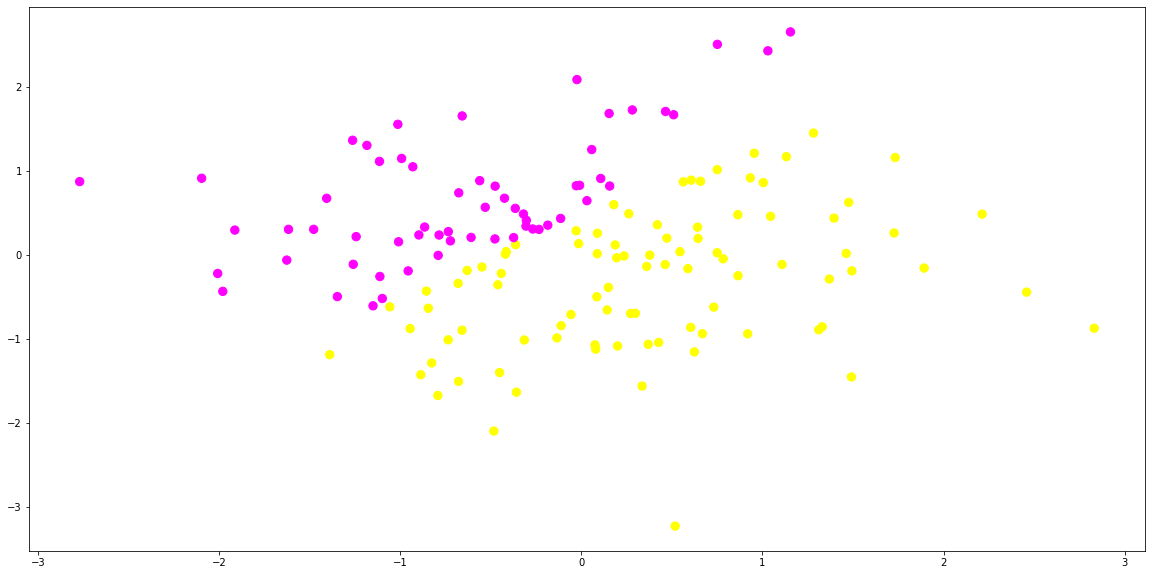

In [4]:
n=150
X=np.random.randn(n,2) #Matrix of size (150,2) from a distribution N(0,1)
w=[1,-1]
b=0.5
Y=np.sign((np.dot(X,w)+0.5))
plt.figure(figsize=(20,10))
plt.scatter(X[:, 0], X[:, 1], c=Y, s = 70, cmap="spring");

Here the data are separable by a line. The SVC module of *scikitlearn* allows to find the separating hyperplane (here a line) which passes with the maximum margin (the smallest distance between the training samples and the separating hyperplane which satisfies the separability condition) separating the data. We then try to solve the following minimization problem:


$$ \min \left\{ \left. \frac{1}{2} \|w\|^2 \right| y_i(<w,x_i>+b)\geq 1, \forall 1\leq i \leq n \right\}$$
-----

In [5]:
clf = SVC(kernel='linear',C=np.Inf)
clf.fit(X, Y)
print (clf.coef_)
print (clf.intercept_)
print (clf.coef_/np.linalg.norm(clf.coef_))
print (w/np.linalg.norm(w))

[[ 37.07035249 -37.3299834 ]]
[19.09734693]
[[ 0.70463494 -0.70957001]]
[ 0.70710678 -0.70710678]


We notice that the *clf.intercept_* and the *clf_coef_* found by the SVC module are the ones we defined in the previous cell with a non null multiplicative coefficient. This is quite normal because the equation of the separating hyperplane is: $(\forall i \in \{1, \cdots , n\}) \ <w,X_{i}> + b = 0$. For a pair $(w,b)$ solution of the problem, the pair $(\alpha w, \alpha b)$ for $\alpha \ne 0$ is obviously also a solution. 

*clf.intercept_* **represents the *b* in the mathematical formulation since the separation is in an affine space.**

We solve by hand the equation $(\forall i \in \{1, \cdots , n\}) : \ \ <w,X_{i}> + b = 0$ and obtain : $ (\forall i \in \{1, \cdots , n\}) : \ \ X_{i,1}= \frac{-1}{w_{1}}(X_{i,0}w_{0} + b)$

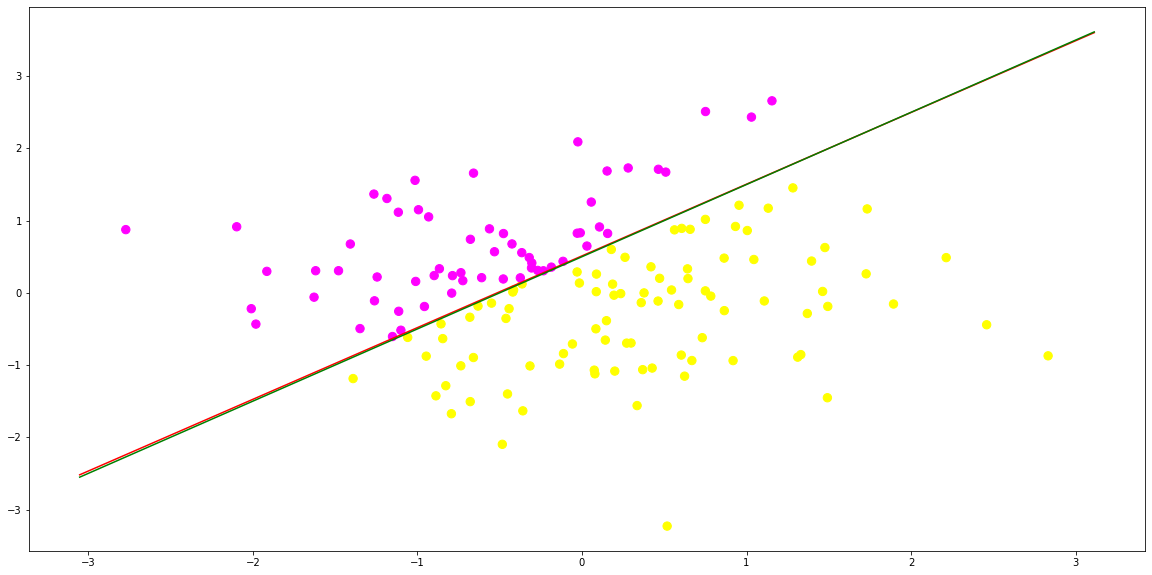

In [6]:
def plot_svc(clf, ax=None):
    if ax is None:
        ax = plt.gca()
    wstar=clf.coef_.ravel()
    x = np.linspace(plt.xlim()[0], plt.xlim()[1], 30)
    ystar = (-1/wstar[1])*(x*wstar[0] + clf.intercept_)
    y = (-1/w[1])*(x*w[0] + b)
    ax.plot(x, ystar, c="red")
    ax.plot(x, y, c="green")
    
plt.figure(figsize=(20,10))
plt.scatter(X[:, 0], X[:, 1], c=Y, s = 70, cmap="spring");
plot_svc(clf,plt.gca())

### I) 2) Case where the data are non-linearly separable

We now consider the non-separable case; some data are not well labeled for linear separation. We then allow some errors in the search for the maximum margin:
$$ \min \left\{ \left. \frac{1}{2} \|w\|^2 + C \sum_{i=1}^n \xi_i \right| y_i(<w,x_i>+b)\geq 1 - \xi_i, \forall 1\leq i \leq n \right\}$$
-----

This minimization is implemented in the SVC module; this is the reason why we put *C=np.Inf* above.
We integrate a noise in the generation of our data to have non separable data.

##### Example 2

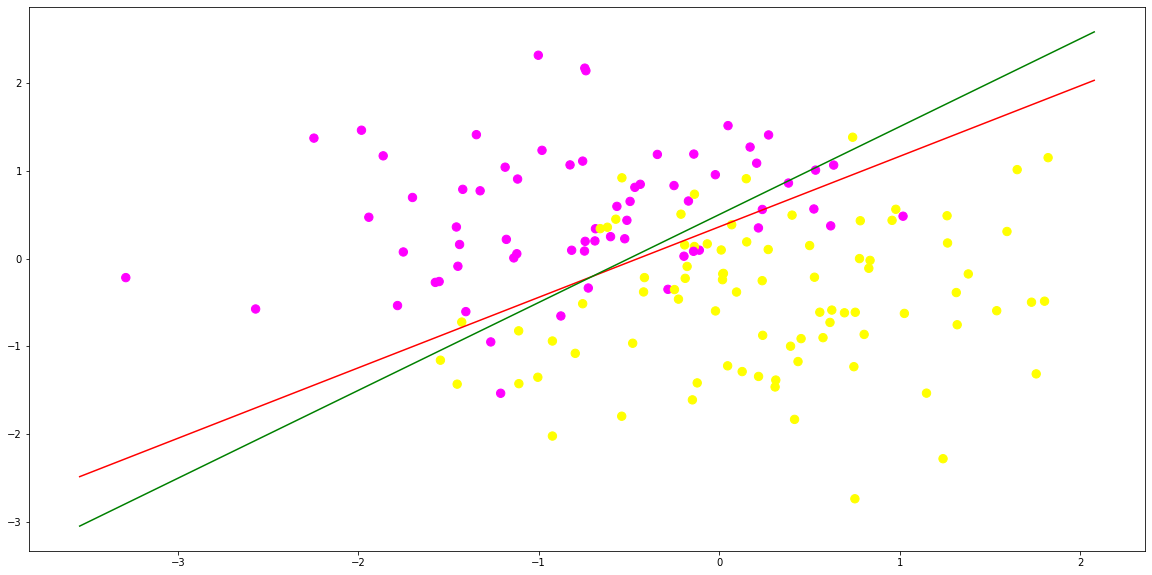

In [7]:
n=150
X=np.random.randn(n,2)
w=[1,-1]
b=0.5
eps=0.7*np.random.randn(n,1)
Y=np.sign((np.dot(X,w)+0.5).reshape(-1,1) + eps).ravel()
plt.figure(figsize=(20,10))
plt.scatter(X[:, 0], X[:, 1], c=Y, s = 70, cmap="spring");

clf = SVC(kernel='linear') #Ici C = 1 par défaut
clf.fit(X, Y)
plot_svc(clf,plt.gca());

It is possible to see the points for which the constraints are active; these are the **support vectors**. They can be found by using the attribute *support_vectors_*.

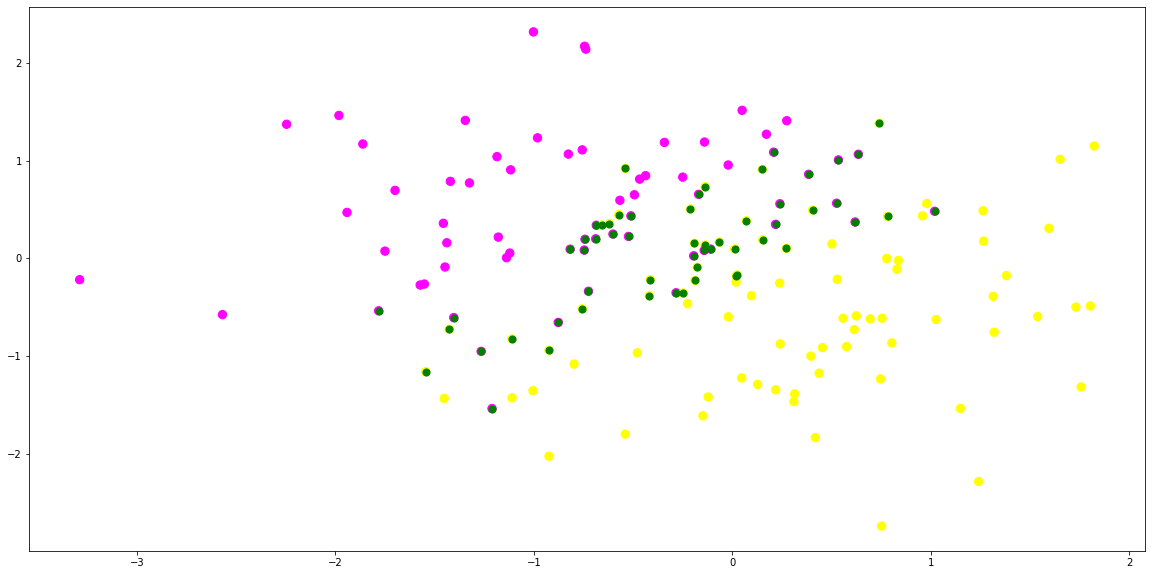

In [8]:
plt.figure(figsize=(20,10))
plt.scatter(X[:, 0], X[:, 1], c=Y, s = 70, cmap='spring')
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=50, facecolors='green');

Using iPython's ``interact`` function, we can see the effect of the constant *C* on the method.

In [7]:
n=150
X=np.random.randn(n,2)
w=[1,-1]
b=0.5
eps=np.random.randn(n,1)
Y=np.sign((np.dot(X,w)+0.5).reshape(-1,1)+eps).ravel()


def call_plot_svc(C):
    plt.scatter(X[:, 0], X[:, 1], c=Y, cmap="spring");
    clf = SVC(kernel='linear',C=C/100)
    clf.fit(X, Y)
    plot_svc(clf,plt.gca());

    
interact(call_plot_svc, C=[1, 50], kernel='linear');

interactive(children=(Dropdown(description='C', options=(1, 50), value=1), Output()), _dom_classes=('widget-in…

In [8]:
clf = SVC(kernel='linear',C=50/100.)
clf.fit(X, Y)
clf.score(X,Y)

0.8266666666666667

In [9]:
clf = SVC(kernel='linear',C=1/100.)
clf.fit(X, Y)
clf.score(X,Y)

0.8333333333333334

SVMs obviously try to minimize the error on the classification (false-positives and false-negatives). Nevertheless, we must not forget that they maximize the margin (minimal distance between the points to be classified and the separating hyperplane). So we also solve: $\arg\displaystyle \max_{w,w_{0}}\displaystyle \min_{k}\{||X - X_{k}|| : X \in \mathbb{R}^{n  \times p}, \ (\forall i \in \{1, \cdots , n\}) : \ <w,X_{i}> + b = 0\}$   

The idea behind maximizing the margin comes from the fact that minimizing the error on the classification concerns only the training data which does not necessarily translate into a minimal error on the validation data. By keeping the maximum margin, we leave "space" for other points potentially of the same class that are in the validation data.  

The parameter $C$ allows to find a compromise between minimizing the error and maximizing the margin. The larger its value the smaller the margin and vice versa. We notice in the cell above that the result for $C = 0.5$ is different than the one for $C = 0.01$.  

This technique allows to have a more flexible margin by allowing classification errors. I use a GridSearch to choose the best value of the parameter $C$ among 4 values for this dataset.

In [9]:
param_grid = {'C' : [0.01, 0.5, 1, 10, 50, 100]}
clf = SVC(kernel='linear')
clf_cv= GridSearchCV(clf,param_grid,cv=5)
clf_cv.fit(X,Y)

GridSearchCV(cv=5, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='linear', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.01, 0.5, 1, 10, 50, 100]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [10]:
clf_cv.best_params_

{'C': 0.5}

In [11]:
clf_cv.best_score_

0.8533333333333333

##### Example 3

We can also generate the data in the following way.
We draw a Gaussian variable centered in $(0,2)$ and then one centered in $(-2,0)$.

The objective is then to find out according to which law the random variable has been drawn.

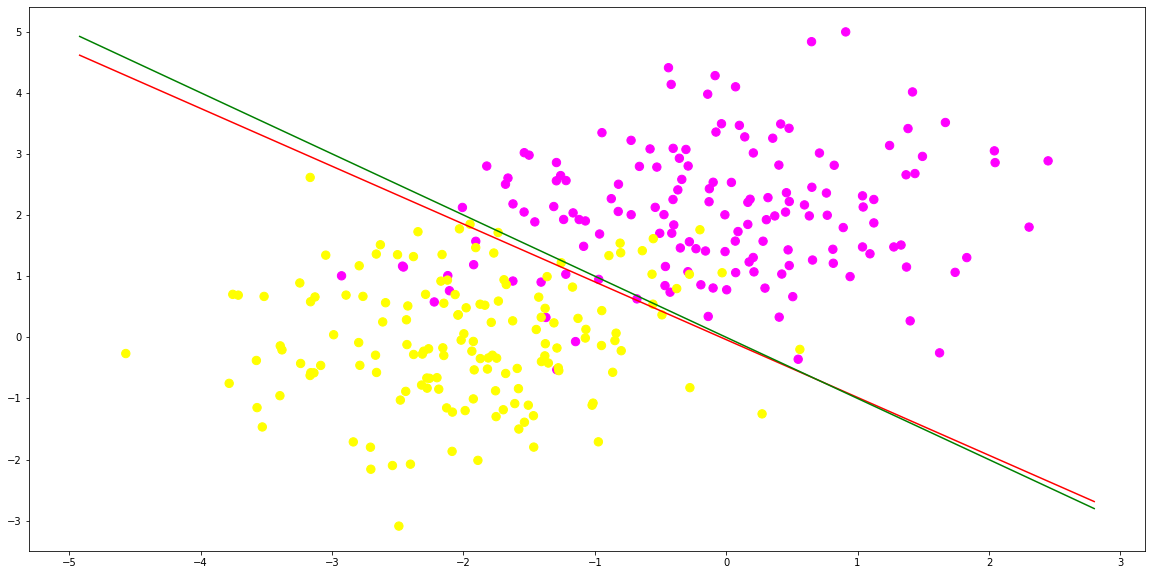

In [12]:
n=150
X=np.append(np.random.randn(n,2)+[0,2],np.random.randn(n,2)+[-2,0],axis=0)
w=[1,1]
b=0
Y=np.append(np.zeros(n),np.ones(n))
plt.figure(figsize=(20,10))
plt.scatter(X[:, 0], X[:, 1], c=Y, s = 70, cmap="spring");

clf = SVC(kernel='linear')
clf.fit(X, Y)
plot_svc(clf,plt.gca());

It is not possible to do better than splitting the space in two to find the origin of the random variable. Here, the random variables are centered on different points which facilitates the linear separability of the data, the further away the centers are with a small standard deviation the easier it is to linearly separate the data. What happens then if this is not the case?

#### Kernel SVM

Kernel SVMs allow to make *linearly* separable data that are not separable, by plunging them into a higher dimensional space.

This time, we define two Gaussian random variables centered in $(0,0)$ with variance $1$ and $16$.

The objective is still to find the law of each of the random variables.

##### Example 4

(300, 2)


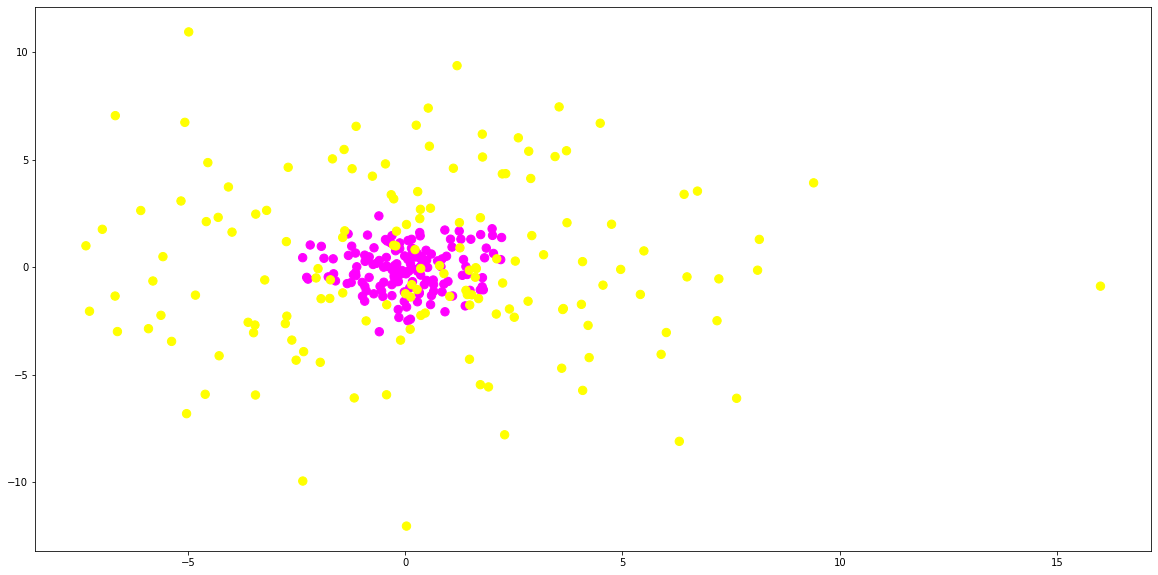

In [13]:
n=150
X=np.append(np.random.randn(n,2),4*np.random.randn(n,2),axis=0)
print (X.shape)
w=[1,1]
b=0
Y=np.append(np.zeros(n),np.ones(n),axis=0)
plt.figure(figsize=(20,10))
plt.scatter(X[:, 0], X[:, 1], c=Y, s = 70, cmap="spring");

In [14]:
def plot_color_decision(clf, ax=None):
    if ax is None:
        ax = plt.gca()

    h=0.05
    # Create color maps
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00'])

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, m_max]x[y_min, y_max].
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    ax.figure(figsize=(20,10))
    ax.pcolormesh(xx, yy, Z, cmap=cmap_light)

    ax.scatter(X[:, 0], X[:, 1], c=Y, cmap=cmap_bold)
    # Plot also the training points
    ax.xlim(xx.min(), xx.max())
    ax.ylim(yy.min(), yy.max())
    ax.title("SVM classification")
    ax.show()

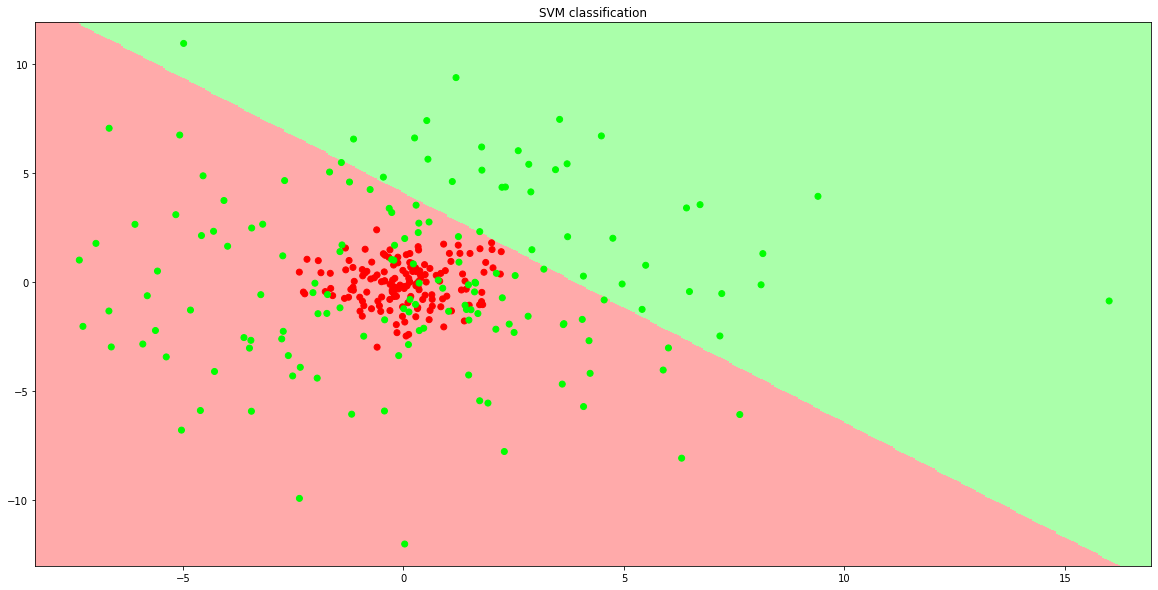

In [15]:
clf = SVC(kernel="linear")
clf.fit(X, Y)
plot_color_decision(clf,plt)

With two random variables centered in $0$ we see directly the limitation of linear separation. In order to circumvent this problem we apply a non-linear $\phi$ transformation on our $X$ data in order to send the data into a higher dimensional and possibly infinite dimensional space (e.g. $L_2$) named **re-description space**. The equation of the separating hyperplane thus becomes: $(\forall i \in \{1, \cdots , n\}) \ <w, \phi(X_{i})> + b = 0$. In the example below we choose a Gaussian kernel which has the following form: $K(X_{0},X_{1}) = e ^{-(X_{0}^2 + X_{1}^2)}$  

In [16]:
r = np.exp(-(X[:, 0] ** 2 + X[:, 1] ** 2))

In [18]:
def plot_3D(elev=30, azim=30):
    ax = plt.subplot(projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], r, c=Y, s=50, cmap='spring')
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('r')

interact(plot_3D, elev=[0, 10,30, 45, 90], azip=(-180, 180));

interactive(children=(Dropdown(description='elev', index=2, options=(0, 10, 30, 45, 90), value=30), IntSlider(…

It is more reasonable here to want to separate the data by a linear plane in this 3D folding! 

The Gaussian kernel (resulting from a folding of the data in an infinite dimensional space) gives the following result.

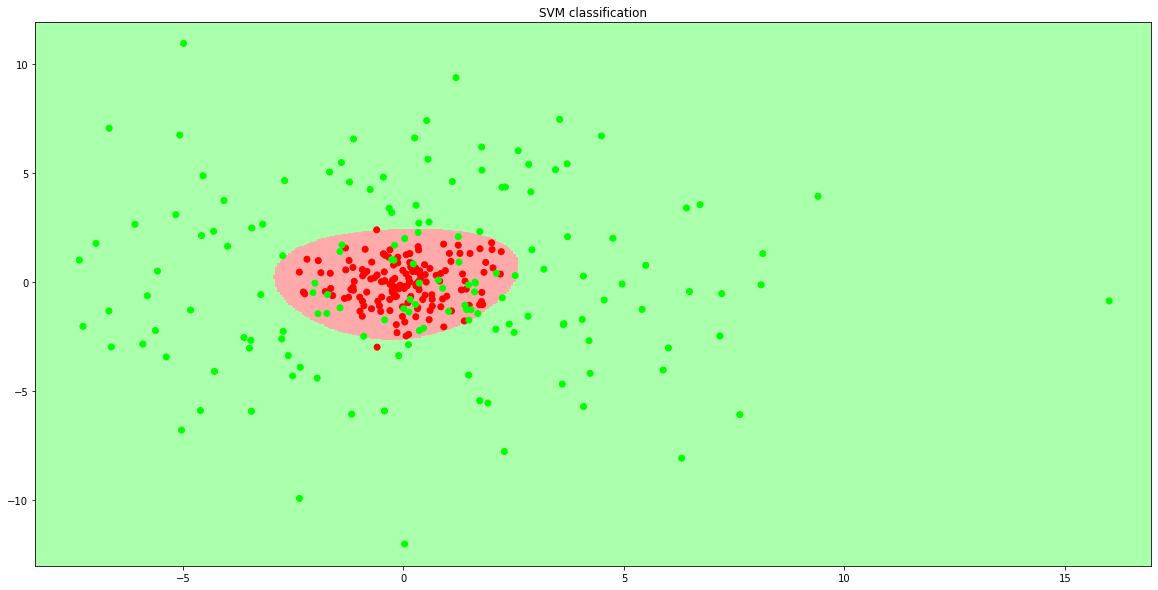

In [17]:
clf = SVC() #Gaussian kernel is used by default by the SVC(), so we have: kernel = "rbf
clf.fit(X, Y)
plot_color_decision(clf,plt)

In [20]:
def call_plot_svc_gamma(gamma):
    clf = SVC(C = 1, gamma = gamma) #Noyau gaussien par défaut kernel = "rbf"
    clf.fit(X, Y)
    plot_color_decision(clf,plt)
    
    
interact(call_plot_svc_gamma, gamma = ["scale", "auto", 0.001, 2]);

interactive(children=(Dropdown(description='gamma', options=('scale', 'auto', 0.001, 2), value='scale'), Outpu…

The gamma noted in the following $\gamma$ is considered as the extent of the decision region which is here a surface. When the gamma is low, the "*curve*" of the decision limit is very low and the decision region is therefore very large. When the gamma is high, the "*curve*" of the decision boundary is high, which creates islands of decision boundaries around the data points.  

- For **$\gamma$ = 0.001** : the decision limit is not very "curved", it is rather a large arc of circle.  

- For **$\gamma$ = 2** : the propagation of the kernel is less pronounced. The decision boundary starts to be strongly affected by the individual data points (i.e. the variance).

## II) K nearest neighbors

#### *Example 1*

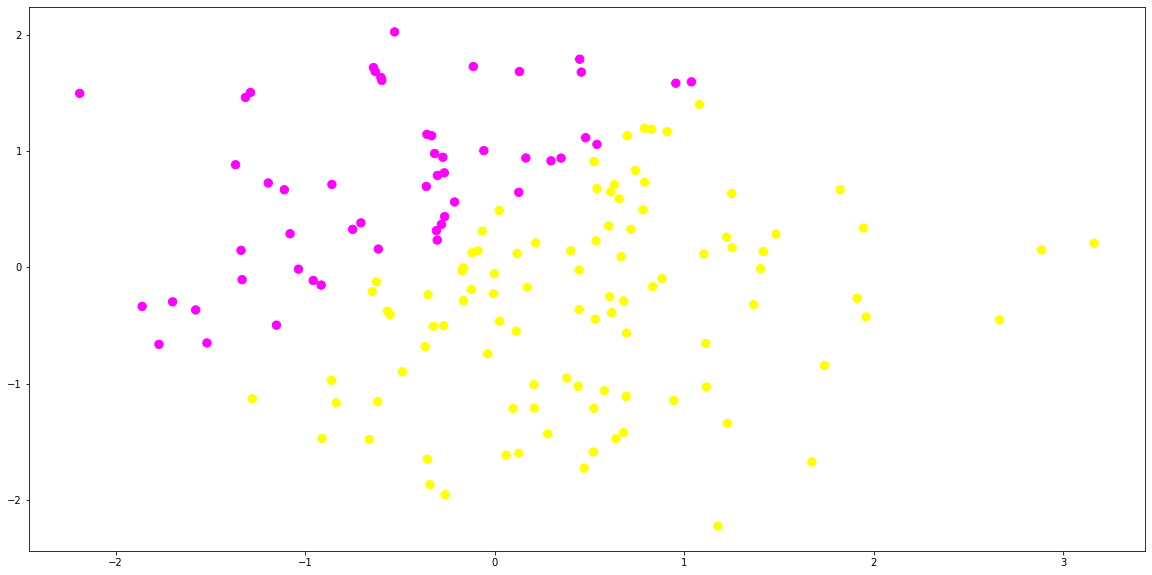

In [21]:
n=150
X=np.random.randn(n,2)
w=[1,-1]
b=0.5
Y=np.sign((np.dot(X,w)+0.5))
plt.figure(figsize=(20,10))
plt.scatter(X[:, 0], X[:, 1], c=Y, s = 70, cmap="spring");

In [19]:
def plot_color_decision_KNN(clf, ax=None):
    if ax is None:
        ax = plt.gca()

    h=0.02
    # Create color maps
    cmap_light = ListedColormap(["gold", "steelblue"])
    cmap_bold = ListedColormap(["darkorange", "deepskyblue"])

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, m_max]x[y_min, y_max].
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    ax.figure(figsize=(20,10))
    ax.pcolormesh(xx, yy, Z, cmap=cmap_light)
    
    ax.scatter(X[:, 0], X[:, 1], c=Y, cmap=cmap_bold, edgecolor='k', s=100)
    # Plot also the training points
    ax.xlim(xx.min(), xx.max())
    ax.ylim(yy.min(), yy.max())
    ax.title("Classification KNN")
    ax.show()

For this first example we simply start by familiarizing ourselves with the KNN method. I randomly choose the number of nearest neighbors equal to 5 without touching any of the default parameters.

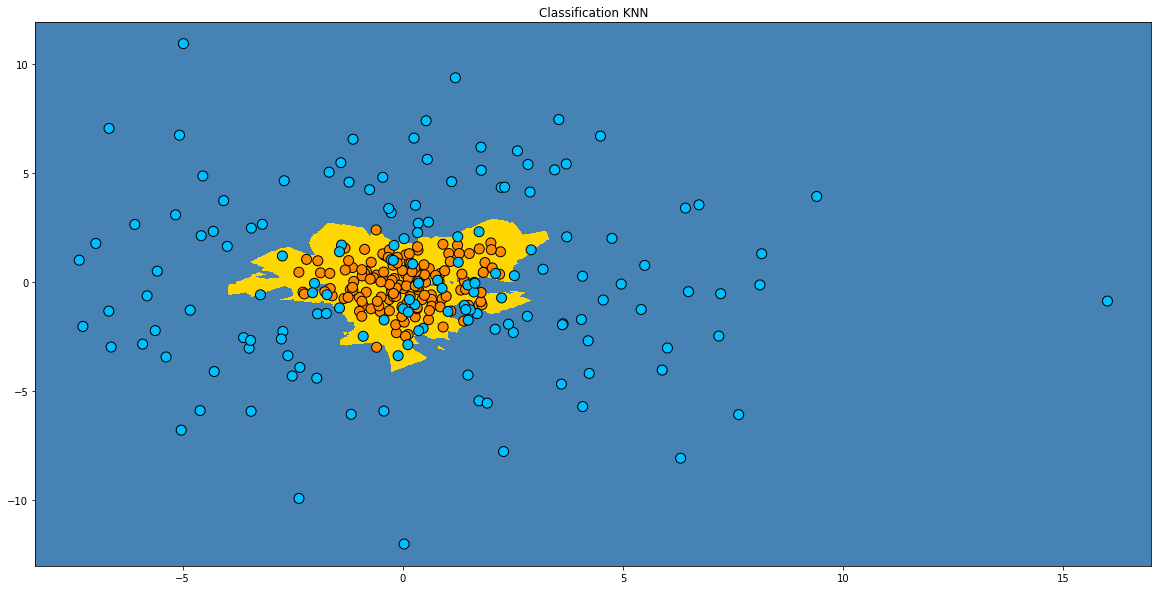

In [20]:
n_neighbors = 5

clf = neighbors.KNeighborsClassifier(n_neighbors)
clf.fit(X, Y)
plot_color_decision_KNN(clf,plt)

Unlike the SVC with a linear kernel, the separation is not done by a straight line. Indeed, by discretizing the space, the label of each point is defined according to the labels of the nearest neighbors. Here, the number of neighbors chosen is 5, to choose the label of a point, it is enough to look at the labels of its neighbors. That's why KNN is called *lazy algorithm* because it only memorizes the points and their distances from each other.

#### *Example 2*

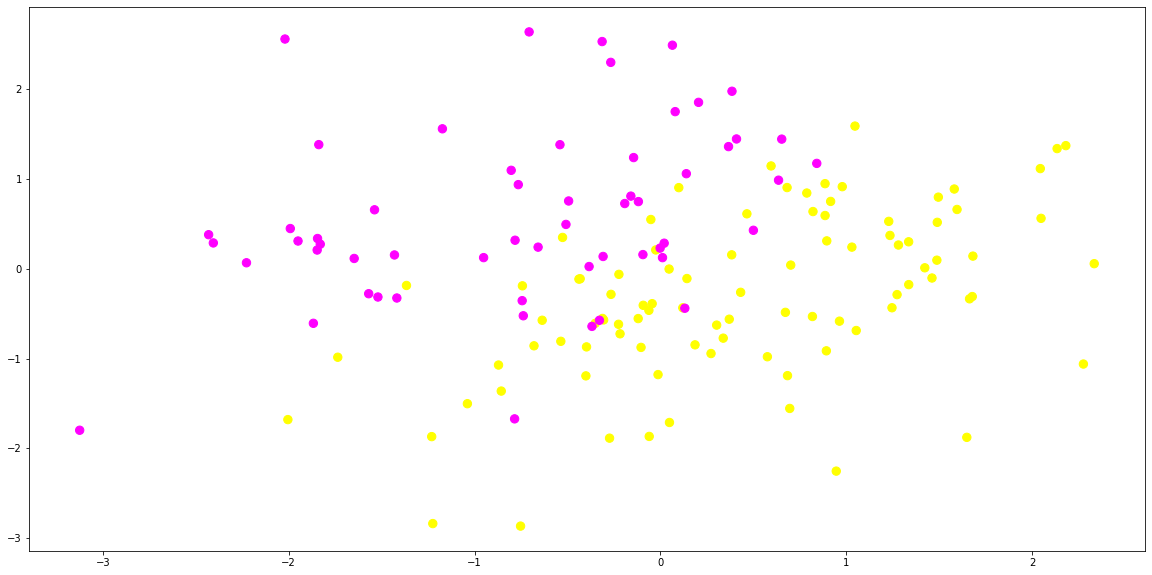

In [24]:
n=150
X=np.random.randn(n,2)
w=[1,-1]
b=0.5
eps=0.7*np.random.randn(n,1)
Y=np.sign((np.dot(X,w)+0.5).reshape(-1,1) + eps).ravel()
plt.figure(figsize=(20,10))
plt.scatter(X[:, 0], X[:, 1], c=Y, s = 70, cmap="spring");

For this second example I explore the two ways of choosing the weights (*weights*). Indeed, there are two methods, namely **uniform** and **distance**.

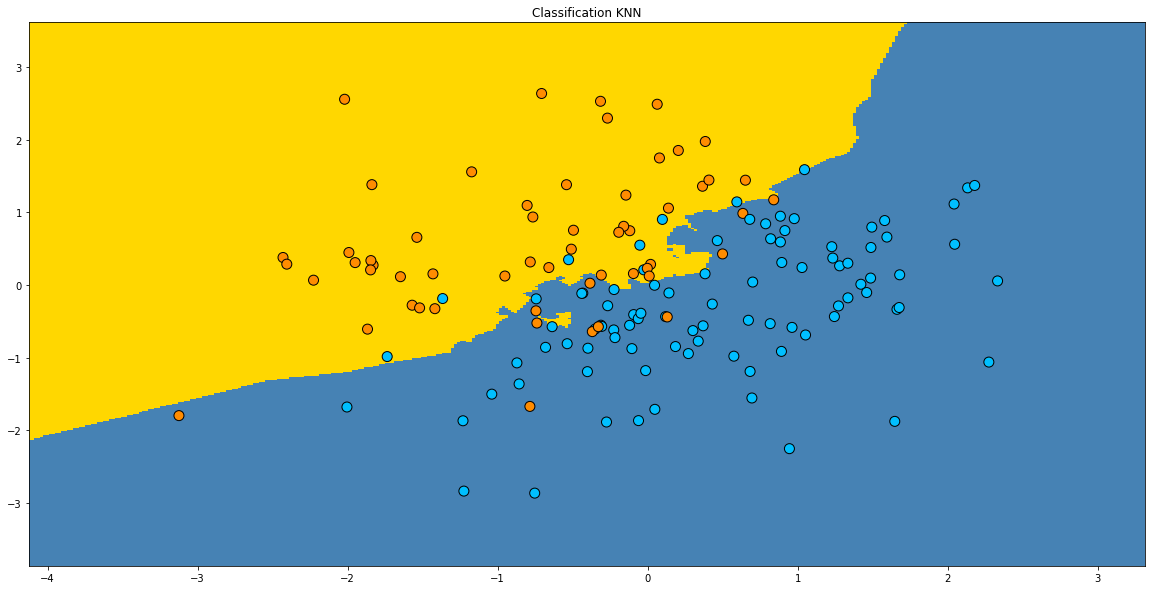

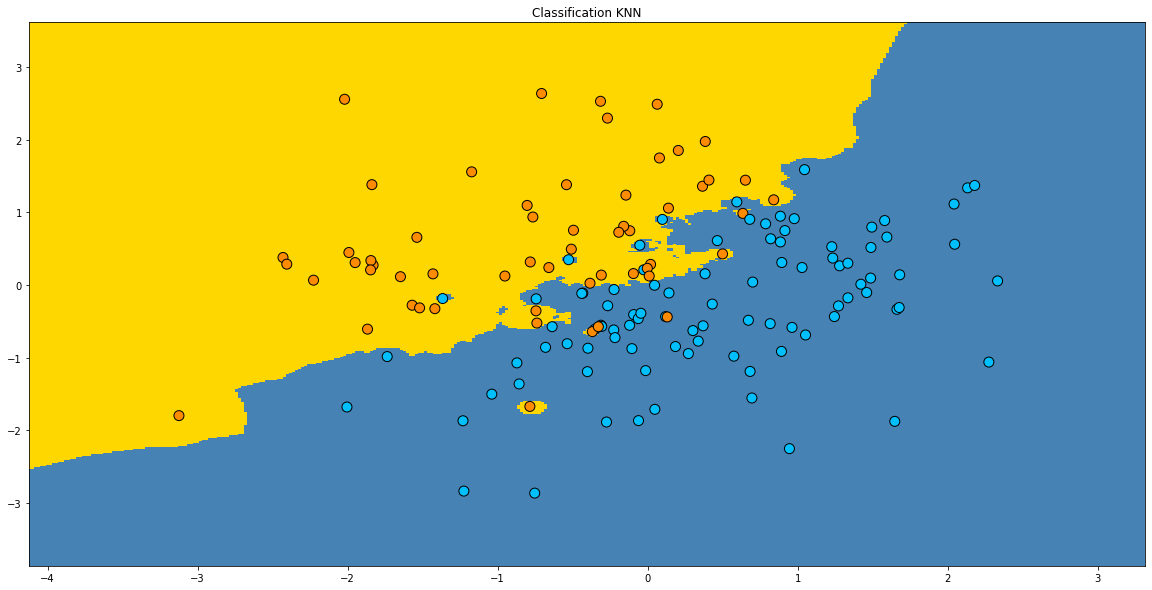

In [25]:
n_neighbors = 5

for weights in ['uniform', 'distance']:
    clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
    clf.fit(X, Y)
    plot_color_decision_KNN(clf,plt)

We notice that changing the weight of the neighbors, changes the decision regions of KNN. Indeed, taking a uniform weight gives equal chances to all the neighbors. On the other hand, choosing a weight inversely proportional to the distance makes the closest points influence more the choice of the label.  

However, we notice the formation of areas containing only one class point, so it smells like overfitting. We therefore use a way seen in class which allows to choose the optimal number of neighbors and which is the **cross validation** through a GridSearch that we explore in *Example 3*.

#### *Example 3*

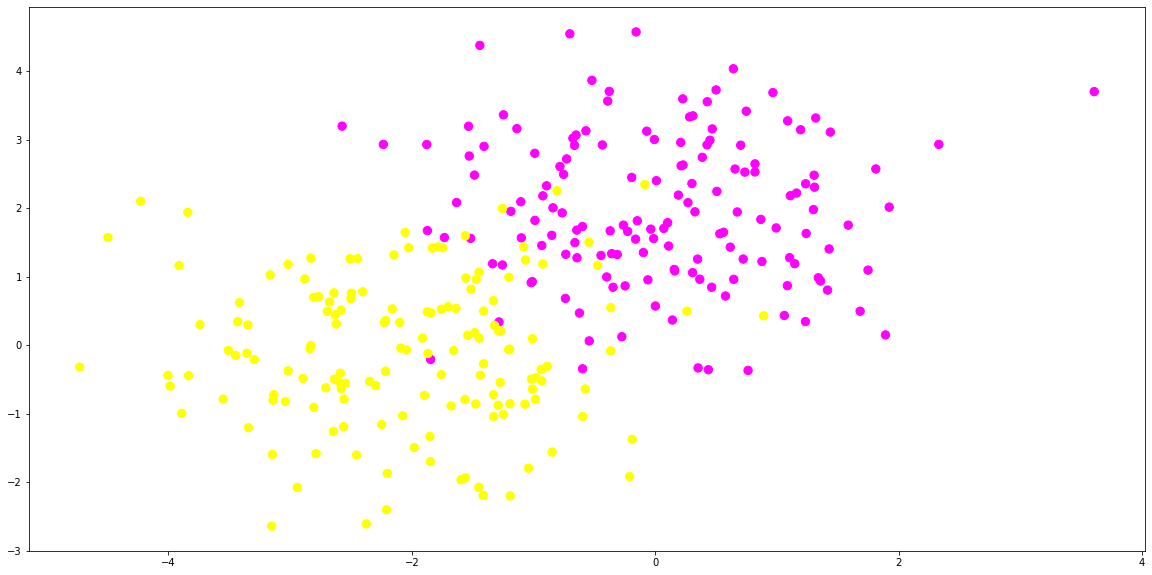

In [26]:
n=150
X=np.append(np.random.randn(n,2)+[0,2],np.random.randn(n,2)+[-2,0],axis=0)
w=[1,1]
b=0
Y=np.append(np.zeros(n),np.ones(n))
plt.figure(figsize=(20,10))
plt.scatter(X[:, 0], X[:, 1], c=Y, s = 70, cmap="spring");

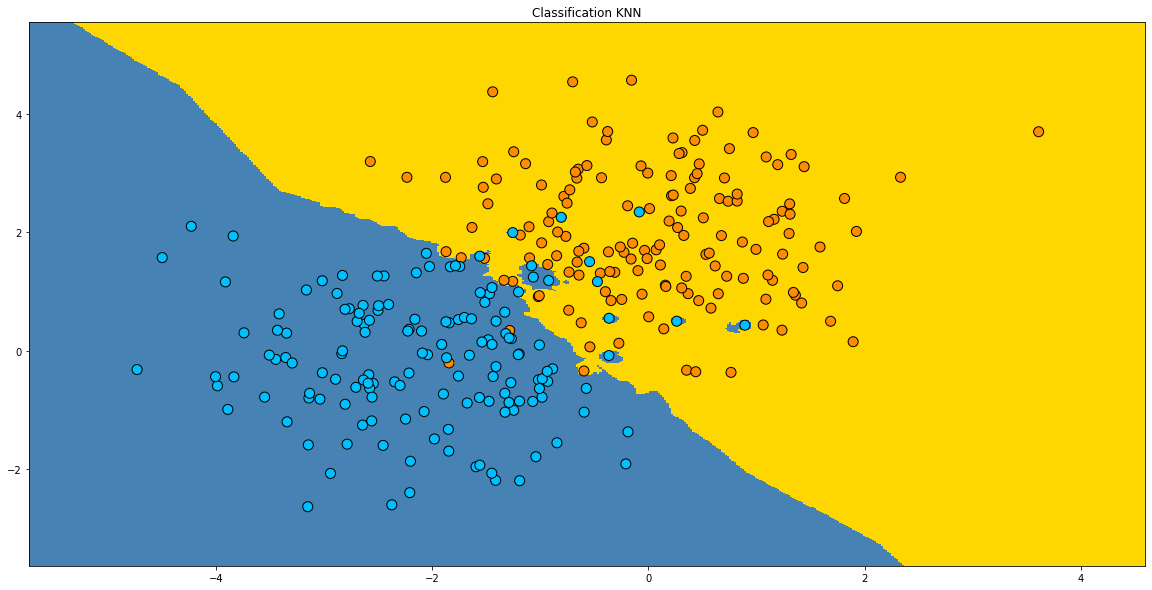

In [27]:
n_neighbors = 5

clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
clf.fit(X, Y)
plot_color_decision_KNN(clf,plt)

In [28]:
param_grid = {'n_neighbors':np.arange(1,50)}
knn = KNeighborsClassifier()
knn_cv= GridSearchCV(knn,param_grid,cv=5)
knn_cv.fit(X,Y)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=None,
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [29]:
knn_cv.best_score_

0.9333333333333333

In [30]:
knn_cv.best_params_

{'n_neighbors': 20}

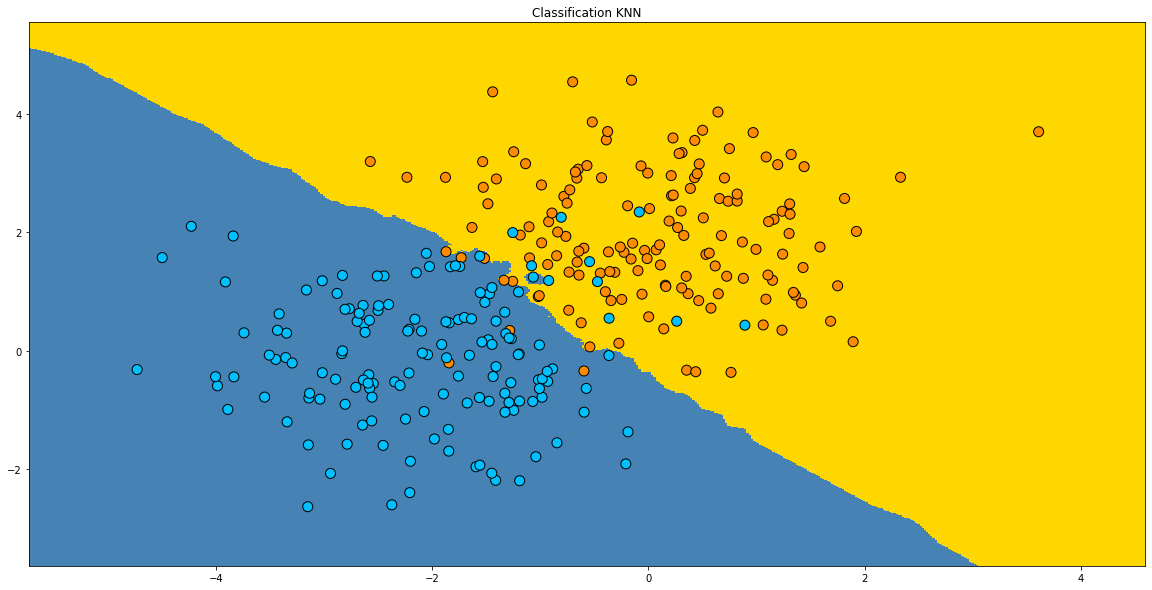

In [31]:
n_neighbors = knn_cv.best_params_['n_neighbors']

clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
clf.fit(X, Y)
plot_color_decision_KNN(clf,plt)

We observe that through cross-validation, the best number of neighbors is different from the one we had chosen at the beginning. This allows us to have decision regions more "adapted" to the generalization and to avoid overfitting. We thus have less areas containing only one or two points and this keeps the capacity of the KNN to generalize on validation data. In *Example 4*, I chose to do both a GridSearch on the choice of weights and on the number of neighbors. The other KNN parameters like the algorithm used or *leaf_size* will not be explored since the dataset does not really allow to see what the modification of these parameters brings.  

Indeed, for the algorithm used, the difference between the *ball_tree*, *kd_tree* and *brute* lies mainly in the complexity of the calculation of the distance matrix and in the amount of data used. Here, the data matrix is small, so we will not see the added value of each method.

#### *Example 4*

(300, 2)


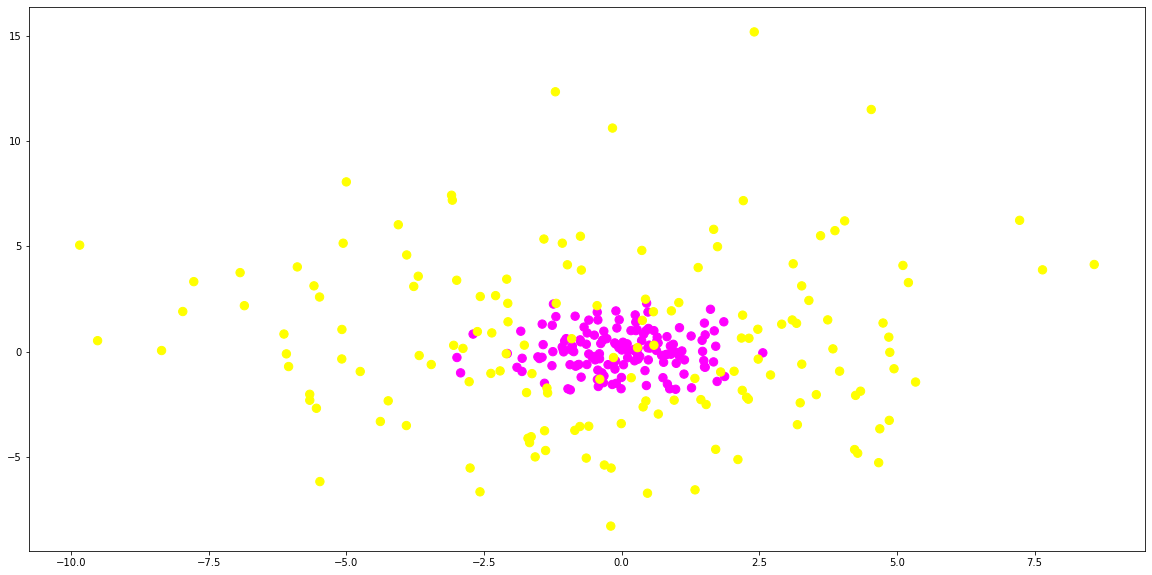

In [32]:
n=150
X=np.append(np.random.randn(n,2),4*np.random.randn(n,2),axis=0)
print (X.shape)
w=[1,1]
b=0
Y=np.append(np.zeros(n),np.ones(n),axis=0)
plt.figure(figsize=(20,10))
plt.scatter(X[:, 0], X[:, 1], c=Y, s = 70, cmap="spring");

In [33]:
param_grid = {'n_neighbors':np.arange(1,50), "weights" : ["uniform", "distance"]}
knn = KNeighborsClassifier()
knn_cv= GridSearchCV(knn,param_grid,cv=5)
knn_cv.fit(X,Y)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=None,
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [34]:
knn_cv.best_score_

0.8733333333333333

In [35]:
knn_cv.best_params_

{'n_neighbors': 7, 'weights': 'distance'}

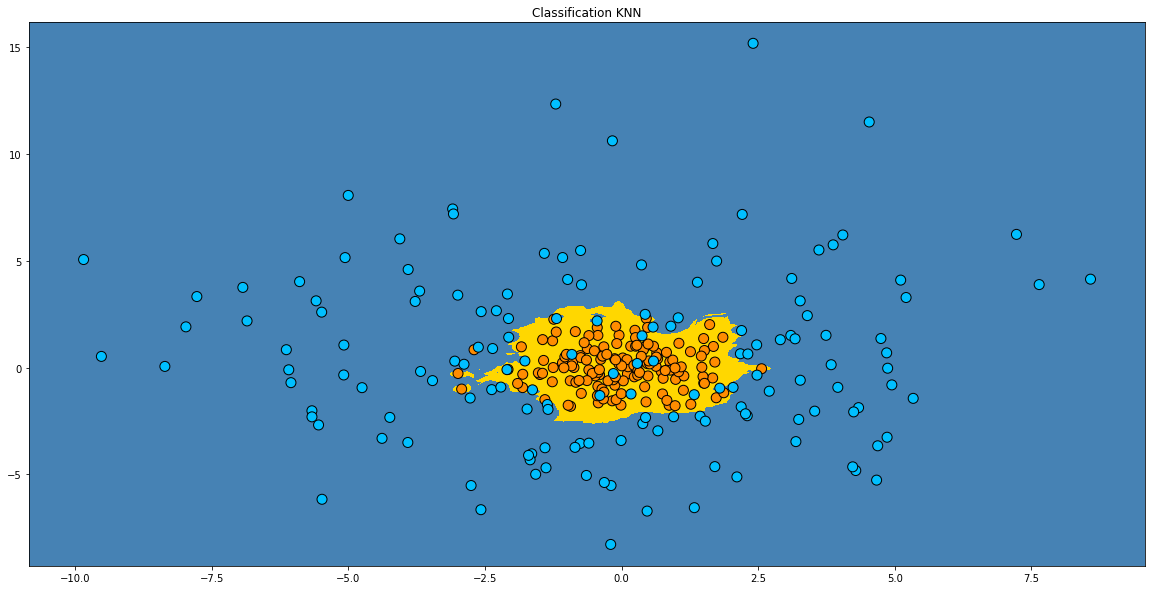

In [36]:
n_neighbors = knn_cv.best_params_['n_neighbors']

clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
clf.fit(X, Y)
plot_color_decision_KNN(clf,plt)

The KNN is therefore "*as successful*" as the SVC with one more dimension (Gaussian kernel). It has the advantage of having a more irregular and possibly discontinuous decision zone.